In [1]:
import csv
import os

!pip install --upgrade tqdm opencv-python einops seaborn tensorflow[and-cuda] imageio

zsh:1: no matches found: tensorflow[and-cuda]


In [2]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from keras import layers, models
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

/Users/bennobrunner/projects/playground/fp-team2-py/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
DATA_DIR = pathlib.Path('./data')
TRAIN_PATH = DATA_DIR / 'train'
VALIDATION_PATH = DATA_DIR / 'validation'
TEST_PATH = DATA_DIR / 'test'

LABELS = np.array([d.name for d in TRAIN_PATH.iterdir() if d.is_dir()])
print(f'LABELS: {LABELS}')

NUM_RIGHT_HAND_LANDMARKS = 21
NUM_LEFT_HAND_LANDMARKS = 21
NUM_FACE_LANDMARKS = 478

LANDMARK_DIMENSIONS = 3

N_FRAMES = 20
FRAME_STEP = 4

def get_class(fname: str):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the dataset. Example name: 'apfel_train_0.mp4'

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[0]

def parse_landmark(row: list[str]):
    """ Parse a row of the landmark CSV file.

        Args:
        row: A row from the CSV file containing landmarks.

        Returns:
        A tuple with the frame
        number, and the x, y, z coordinates of the landmark.
    """
    if len(row) > 1:
        body_part = row[0]
        x = float(row[1].split(':')[1].strip())
        y = float(row[2].split(':')[1].strip())
        z = float(row[3].split(':')[1].strip())
        return x, y, z
    return None, None, None, None

def landmarks_per_class(class_name: str, path: pathlib.Path):
    for root, _, files in os.walk(path/class_name/'landmarks'):
        landmarks_per_classes = []
        file_index = 0
        for file in files:
            landmarks_for_file = []
            reader = csv.reader(open(os.path.join(root, file)))
            frame_number = 0
            frame_landmarks = []
            for row in reader:
                if not row:
                    continue
                if row[0].startswith('frame'):
                    if frame_landmarks:
                        landmarks_for_file.append(frame_landmarks)
                        if len(frame_landmarks) < 520:
                            for i in range(520 - len(frame_landmarks)):
                                frame_landmarks.append([0.0, 0.0, 0.0])
                        frame_landmarks = []
                    frame_number = row[0].split()[1]
                else:
                    frame_landmarks.append(parse_landmark(row))
            file_index += 1
            if len(landmarks_for_file) < 350:
                for i in range(350 - len(landmarks_for_file)):
                    file_buffer = []
                    for j in range(520):
                        file_buffer.append([0.0, 0.0, 0.0])
                    landmarks_for_file.append(file_buffer)

            landmarks_per_classes.append(landmarks_for_file)
    return landmarks_per_classes

train = []
test = []
validation = []
for label in LABELS:
    print(f'Landmarks for {label}:')
    train.append(landmarks_per_class(label, TRAIN_PATH))
    test.append(landmarks_per_class(label, TEST_PATH))
    validation.append(landmarks_per_class(label, VALIDATION_PATH))


encoder = LabelBinarizer()
transformed_labels = encoder.fit_transform(LABELS)


LABELS: ['apfel' 'kiwi' 'banane' 'fleisch' 'tomate' 'paprika' 'himbeere' 'ananas'
 'erdbeere' 'zwiebel']
Landmarks for apfel:
Landmarks for kiwi:
Landmarks for banane:
Landmarks for fleisch:
Landmarks for tomate:
Landmarks for paprika:
Landmarks for himbeere:
Landmarks for ananas:
Landmarks for erdbeere:
Landmarks for zwiebel:


In [7]:
train = np.array(train)
x_train = np.reshape(train, (140, 350, 520, 3))

y_train = []
for j in range(10):
    for i in range(14):
        y_train.append(j)
y_train = np.array(y_train)

x_test = np.array(test)
x_test = np.reshape(test, (20, 350, 520, 3))
y_test = []
x_validation = np.array(validation)
x_validation = np.reshape(validation, (20, 350, 520, 3))
y_validation= []

for j in range(10):
    for i in range(2):
        y_test.append(j)
        y_validation.append(j)

y_test = np.array(y_test)
y_validation = np.array(y_validation)

In [8]:
def create_landmark_model(num_frames, num_body_parts, num_classes=10):
    """
    Create a CNN model for classifying body landmark sequences.

    Args:
        num_frames: Number of frames in each sequence
        num_body_parts: Number of body parts tracked
        num_classes: Number of classification categories

    Returns:
        A compiled Keras model
    """
    # Input shape: [batch_size, frames, body_parts, 3]  (3 for x, y, z)

    inputs = layers.Input(shape=(350, 520, 3), batch_size=2)

    # First, process each frame with shared weights across time
    x = layers.TimeDistributed(layers.Conv1D(32, kernel_size=2, padding='same', activation='relu'))(inputs)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.MaxPooling1D(pool_size=1))(x)

    # Second convolutional block
    x = layers.TimeDistributed(layers.Conv1D(128, kernel_size=1, padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.MaxPooling1D(pool_size=1))(x)

    # Flatten the spatial dimensions but keep the temporal dimension
    x = layers.TimeDistributed(layers.Flatten())(x)

    # Process the sequence with LSTM to capture temporal relationships
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.5)(x)

    # Classification head
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:

model = create_landmark_model(20, 3, 10)
# model.summary()

batch_size = 5
num_frames = 20
num_body_parts = 3


history = model.fit(
    x = x_train,
    y = y_train,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=5,
)


Epoch 1/200
 2/28 ━━━━━━━━━━━━━━━━━━━━ 50:53 117s/step - accuracy: 0.0000e+00 - loss: 2.3176  

KeyboardInterrupt: 

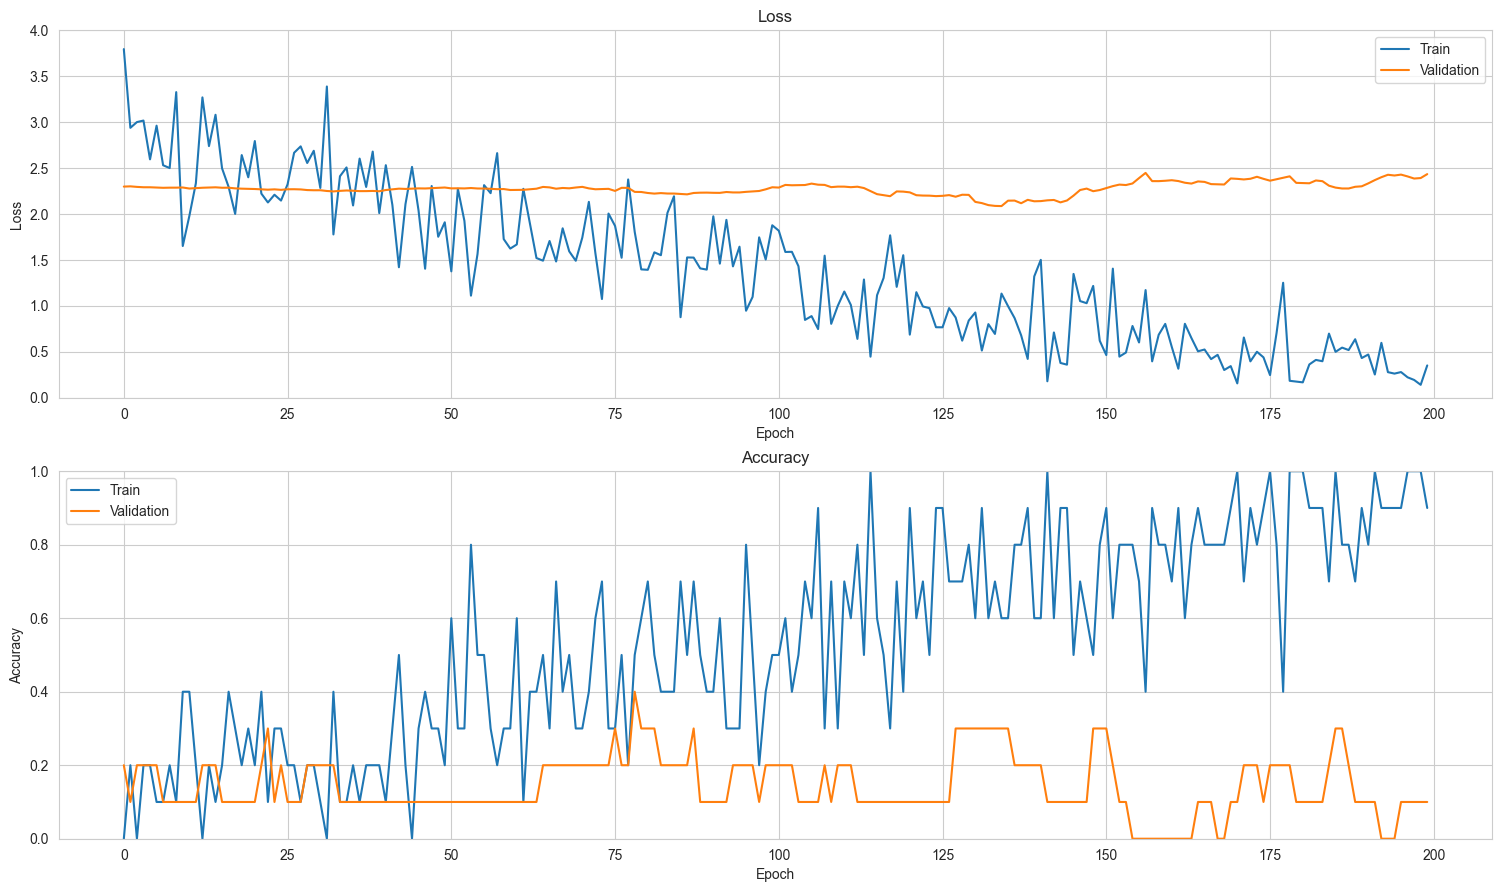

In [8]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#Predict
y_prediction = model.predict(validation)
y_prediction = np.argmax (y_prediction, axis = 1)

y_prediction = encoder.inverse_transform(y_prediction)
print(y_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(range(10), y_prediction , labels=LABELS, normalize='pred')

plt.figure(figsize=(3,3))
cmp = ConfusionMatrixDisplay(confusion_matrix=result)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


AxisError: axis 1 is out of bounds for array of dimension 1